In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
PROJECT_DIR = os.path.expanduser("~/wildfire_burn_scars_segmentation")
print(PROJECT_DIR)
sys.path.append(os.path.join(PROJECT_DIR, 'src'))

/home/rgura001/wildfire_burn_scars_segmentation


In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

from torchinfo import summary as torchinfo_summary

2.9.0+cu128
True
8


## Dataset

In [4]:
from dataloading.hls_burn_scars_dataset import create_dataloaders
train_loader, val_loader, data_info = create_dataloaders(
	data_dir=os.path.join(PROJECT_DIR, "data/hls_burn_scars"),
	# processor=processor,
	batch_size=4,
	num_workers=4,
)

print(data_info)

batch = next(iter(val_loader))
print(batch['image'].shape)
print(batch['image'].min(), batch['image'].max())
print(batch['mask'].shape)
print(batch['mask'].unique())

Found 540 images in training split
Found 264 images in validation split
{'input_shape': (4, 3, 512, 512), 'num_classes': 2}
torch.Size([4, 3, 512, 512])
tensor(0.) tensor(0.5148)
torch.Size([4, 512, 512])
tensor([  0,   1, 255])


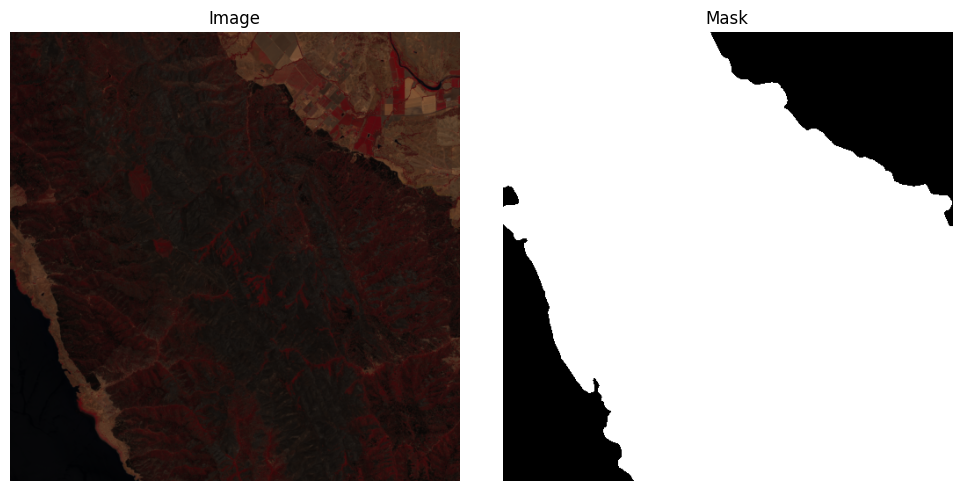

In [5]:
from visualize.plot_data import plot_datapoint

plot_datapoint(batch['image'][0].cpu().numpy().transpose(1,2,0), 
				batch['mask'][0].cpu().numpy(),
				show=True
			)

## Model

In [17]:
from models.segformer import build_model

model, processor = build_model(num_classes=data_info['num_classes'])

# Model summary
torchinfo_summary(model, 
	data=(next(iter(train_loader))), 
	# input_shape=data_info['input_shape']
)

/home/rgura001/miniconda3/envs/finetune-segformer-env/lib/python3.12/site-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


Layer (type:depth-idx)                                                      Param #
SegformerForSemanticSegmentation                                            --
├─SegformerModel: 1-1                                                       --
│    └─SegformerEncoder: 2-1                                                --
│    │    └─ModuleList: 3-1                                                 (485,472)
│    │    └─ModuleList: 3-2                                                 (2,832,896)
│    │    └─ModuleList: 3-3                                                 (1,024)
├─SegformerDecodeHead: 1-2                                                  --
│    └─ModuleList: 2-2                                                      --
│    │    └─SegformerMLP: 3-4                                               8,448
│    │    └─SegformerMLP: 3-5                                               16,640
│    │    └─SegformerMLP: 3-6                                               41,216
│    │    └─Seg

In [21]:
from models.segformer import build_model, build_peft_model

base_model, processor = build_model(num_classes=data_info['num_classes'])
model = build_peft_model(base_model,
	lora_r=8,
	lora_alpha=16,
	lora_dropout=0.1
)

torchinfo_summary(model)

/home/rgura001/miniconda3/envs/finetune-segformer-env/lib/python3.12/site-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


Layer (type:depth-idx)                                                                Param #
PeftModelForFeatureExtraction                                                         --
├─LoraModel: 1-1                                                                      --
│    └─SegformerForSemanticSegmentation: 2-1                                          --
│    │    └─SegformerModel: 3-1                                                       3,368,544
│    │    └─SegformerDecodeHead: 3-2                                                  (395,266)
Total params: 3,763,810
Trainable params: 49,152
Non-trainable params: 3,714,658